<a href="https://colab.research.google.com/github/m10singh94/ClassificationAndBoundingBoxPrediction/blob/main/ClassificationWithBoundingBoxPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classification with Bounding Box Prediction
We will create a  `ResNet model` using Transfer Learning to detect the class of image (either a dog or a cat) and also the bounding box, and try to demonstrate a demo of the model in Gradio in HuggingFace Space.

## 1 Starting with Importing all the required Libraries
* torch
* torchvision
* matplotlib
* torchinfo
* sklearn
* cv2
* pandas
* requests (etc.)


In [1]:
# importing torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

from pathlib import Path
import os
import zipfile
import requests
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2 Getting Data

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maitsingh","key":"b48511fa6d8df5b23fc91c558e9b263e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets list

In [5]:
! kaggle datasets download -d andrewmvd/dog-and-cat-detection

 98% 1.01G/1.03G [00:09<00:00, 96.4MB/s]
100% 1.03G/1.03G [00:09<00:00, 111MB/s] 


In [6]:
data_path = Path("data/")
folder_path = data_path / "cat_dog"

if folder_path.is_dir():
  print(f"{folder_path} exists.")
else:
  print(f"{folder_path} doesn't exist, creating one.")
  folder_path.mkdir(parents=True, exist_ok=True)

# As dataset's already downloaded, changing the directory
!mv ./dog-and-cat-detection.zip ./data/cat_dog/dog-and-cat-detection.zip

with zipfile.ZipFile(folder_path / "dog-and-cat-detection.zip", "r") as zip_ref:
  print("Unzipping cat and dog...")
  zip_ref.extractall(folder_path)
  print("Unzipping completed!")

!rm ./data/cat_dog/dog-and-cat-detection.zip
print("Directory ready to be used!")

data/cat_dog doesn't exist, creating one.
Unzipping cat and dog...
Unzipping completed!
Directory ready to be used!


## 3 Plot an image and it's bounding box

In [7]:
directory = folder_path / 'annotations'
annotations = os.listdir(directory)
# specifying image dir
image_path = folder_path / "images"

In [8]:
with open(os.path.join(directory,'Cats_Test101.xml'), 'r') as f:
        file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

(375, 500, 3)


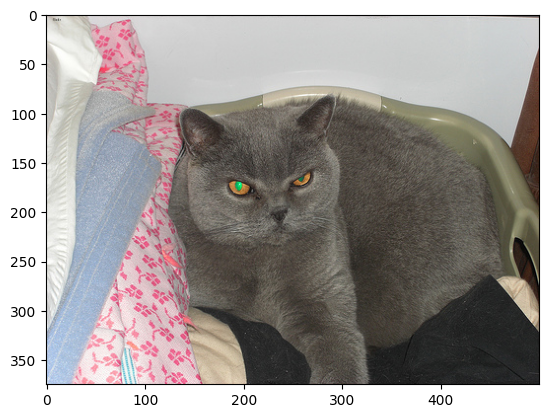

In [9]:
import cv2
img = cv2.imread(str(folder_path) + "/images/Cats_Test101.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

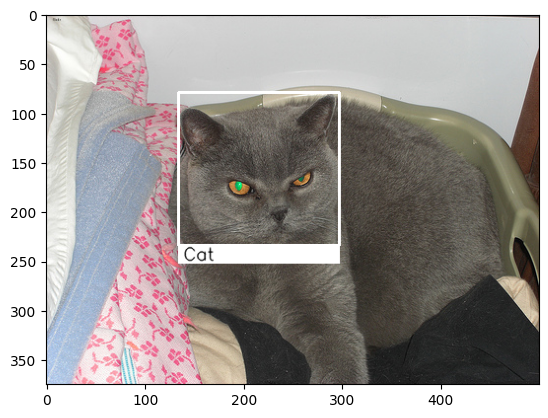

In [10]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=1

img = cv2.rectangle(img, (xmin, ymin), (xmax,ymax), (255,255,255), 2)
img = cv2.rectangle(img,(xmin,ymax),(xmax,ymax+18),(255,255,255),-1)
img = cv2.putText(img,"Cat",(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

plt.imshow(img)

Random image path: data/cat_dog/images/Cats_Test1001.png
Image height: 358
Image width: 500
Image shape: (500, 358)


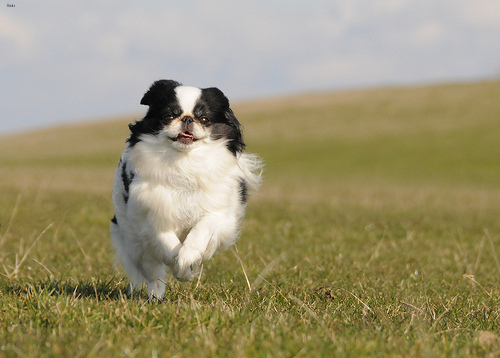

In [11]:
random_image_path = folder_path / "images" / "Cats_Test1001.png"
random_img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image height: {random_img.height}")
print(f"Image width: {random_img.width}")
print(f"Image shape: {random_img.size}")
random_img

## 4 Preparing dataset
Converting `.xml` files to dataframes that can be used as dataset.

In [12]:
images = []
labels = []
bboxes = []
image_paths = []

for file in annotations:
  with open(os.path.join(directory,file), 'r') as f:
    content = f.read()

  data = BeautifulSoup(content, 'xml')

  filename = data.find("filename").text.strip()
  width = int(data.find("size").width.text)
  height = int(data.find("size").height.text)
  class_name = data.find("object").find("name").text
  xmin = float(data.find("object").find("bndbox").find("xmin").text) / width
  ymin = float(data.find("object").find("bndbox").find("ymin").text) / height
  xmax = float(data.find("object").find("bndbox").find("xmax").text) / width
  ymax = float(data.find("object").find("bndbox").find("ymax").text) / height

  image = cv2.imread(str(image_path) + '/' + filename)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  images.append(image)
  labels.append(class_name)
  bboxes.append((xmin, ymin, xmax, ymax))
  image_paths.append(filename)

In [13]:
images = np.array(images, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)

le = LabelEncoder()
labels = le.fit_transform(labels)

In [14]:
class_names = le.classes_

In [15]:
class_names[0]

'cat'

In [16]:
split = train_test_split(images, labels, bboxes, image_paths, test_size=0.20,
                         random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [17]:
(trainImages, testImages) = torch.tensor(trainImages), torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels), torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes), torch.tensor(testBBoxes)

In [18]:
%%writefile datasetgenerator.py
"""
Contains DatasetGenrator and creates a dataset
"""

import torch
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import os
import pathlib
from PIL import Image

class CustomDatasetGenerator(Dataset):
  def __init__(self, tensors, transform=None):
    self.tensors = tensors
    self.transform = transform

  def __len__(self):
	  return len(self.tensors[0])

  def __getitem__(self, index):
    image = self.tensors[0][index]
    label = self.tensors[1][index]
    bbox = self.tensors[2][index]

    image = image.permute(2,0,1)
    if self.transform:
      image = self.transform(image)

    return (image, label, bbox)

Writing datasetgenerator.py


## 5 Creating *Transforms* for training and testing dataset

In [19]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

## 6 Creating `Dataset` and `DataLoader` for our dataset

In [20]:
from datasetgenerator import CustomDatasetGenerator

train_data_custom = CustomDatasetGenerator((trainImages, trainLabels, trainBBoxes),
                                           transform=train_transform)
test_data_custom = CustomDatasetGenerator((testImages, testLabels, testBBoxes),
                                          transform=test_transform)
train_data_custom, test_data_custom

(<datasetgenerator.CustomDatasetGenerator at 0x786b2c62a980>,
 <datasetgenerator.CustomDatasetGenerator at 0x786b2c62bd60>)

In [21]:
print(f"[INFO] total training samples: {len(train_data_custom)}")
print(f"[INFO] total test samples: {len(test_data_custom)}")

[INFO] total training samples: 2948
[INFO] total test samples: 738


In [22]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
PIN_MEMORY = True if device == "cuda" else False

In [23]:
train_dataloader = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True,
                              pin_memory=PIN_MEMORY) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=PIN_MEMORY) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x786b2c62a6b0>,
 <torch.utils.data.dataloader.DataLoader at 0x786b2c62b340>)

### 6.1 Testing DataLoader

In [24]:
img, label, bbox = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"Bbox shape: {bbox.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
Bbox shape: torch.Size([32, 4])


torch.Size([224, 224, 3])


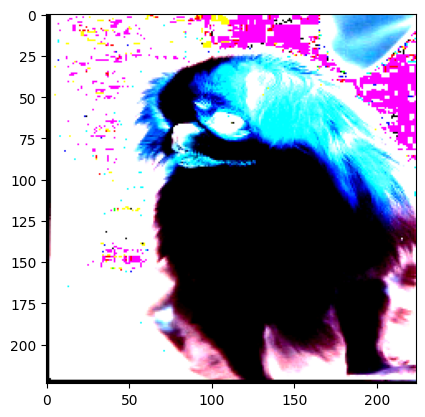

In [25]:
img = img[0].squeeze().permute(1,2,0)
print(img.shape)
plt.imshow(img)

In [26]:
%%writefile objectdetector.py
from torch import nn

class ObjectDetector(nn.Module):
  def __init__(self, baseModel, numClasses):
    super(ObjectDetector, self).__init__()
    self.baseModel = baseModel
    self.numClasses = numClasses

    # regressor layer
    self.regressor = nn.Sequential(
      nn.Linear(baseModel.fc.in_features, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 4),
      nn.Sigmoid()
    )

    # classification layer
    self.classifier = nn.Sequential(
      nn.Linear(baseModel.fc.in_features, 512),
      nn.ReLU(),
      nn.Dropout(p=0.2),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Dropout(p=0.2),
      nn.Linear(512, self.numClasses)
    )

    # The final step is to make the base model’s fully connected layer into an
    # Identity layer, which means it’ll mirror the outputs produced by the
    # convolution block right before it
    self.baseModel.fc = nn.Identity()

  def forward(self, x):
    features = self.baseModel(x)
    bbox = self.regressor(features)
    classLogits = self.classifier(features)
    return bbox, classLogits

Writing objectdetector.py


In [27]:
%%writefile engine.py
"""
Contains train_step, test_step and train function to train the model.
"""

from typing import Tuple, Dict, List
import torch
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               class_loss_fn: torch.nn.Module,
               bbox_loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # putting model in train mode
  model.train()

  # initialising train loss and accuracy
  train_loss, train_acc = 0, 0

  # loop through data loader data batches
  for batch, (X, y, bboxes) in enumerate(dataloader): # X=images, y=labels
      # Send data to target device
      X, y, bboxes = X.to(device), y.to(device), bboxes.to(device)

      bbox_pred, y_pred_logits = model(X)
      bbox_loss = bbox_loss_fn(bbox_pred, bboxes)
      class_loss = class_loss_fn(y_pred_logits, y)
      total_loss = bbox_loss + class_loss
      train_loss += total_loss.item()

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

# ------------------------------------------------------------------------------

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              class_loss_fn: torch.nn.Module,
              bbox_loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Putting model to eval mode
  model.eval()

  # initialising test loss and accuracy
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y, bboxes) in enumerate(dataloader):
        X, y, bboxes = X.to(device), y.to(device), bboxes.to(device)

        bbox_pred, test_pred_logits = model(X)
        bbox_loss = bbox_loss_fn(bbox_pred, bboxes)
        class_loss = class_loss_fn(test_pred_logits, y)
        total_loss = bbox_loss + class_loss
        test_loss += total_loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

# ------------------------------------------------------------------------------

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          class_loss_fn: torch.nn.Module,
          bbox_loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          class_loss_fn=class_loss_fn,
                                          bbox_loss_fn=bbox_loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          class_loss_fn=class_loss_fn,
                                          bbox_loss_fn=bbox_loss_fn,
                                          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing engine.py


In [28]:
%%writefile utils.py
"""
Contains save_model function that saves the .pth or .pt file to the target
directory
"""

from pathlib import Path
import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing utils.py


## 7 Initialising Model

In [29]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)

for param in resnet.parameters():
	param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 245MB/s]


In [30]:
resnet.fc.in_features

2048

In [31]:
from objectdetector import ObjectDetector

# initialising our model
objectDetector = ObjectDetector(baseModel=resnet,
                                # in_features=resnet.fc.in_features,
                                numClasses=len(le.classes_))
summary(model=objectDetector,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [32, 3, 224, 224]    [32, 4]              --                   Partial
├─ResNet (baseModel)                          [32, 3, 224, 224]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

## 8 Training the Model

In [37]:
import engine, utils

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# initialising losses
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()

# optimizer
optim = torch.optim.Adam(params=objectDetector.parameters(), lr=1e-3)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = engine.train(model=objectDetector,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optim,
                        class_loss_fn=class_loss_fn,
                        bbox_loss_fn=bbox_loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
utils.save_model(model=objectDetector,
           target_dir="models",
           model_name="resnet_bbox_prediction_model.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0398 | train_acc: 0.9896 | test_loss: 0.4558 | test_acc: 0.9310
Epoch: 2 | train_loss: 0.0402 | train_acc: 0.9892 | test_loss: 0.0632 | test_acc: 0.9831
Epoch: 3 | train_loss: 0.0158 | train_acc: 0.9970 | test_loss: 0.0968 | test_acc: 0.9779
Epoch: 4 | train_loss: 0.0237 | train_acc: 0.9943 | test_loss: 0.1070 | test_acc: 0.9740
Epoch: 5 | train_loss: 0.0378 | train_acc: 0.9879 | test_loss: 0.0593 | test_acc: 0.9792
Epoch: 6 | train_loss: 0.0081 | train_acc: 0.9990 | test_loss: 0.0967 | test_acc: 0.9792
Epoch: 7 | train_loss: 0.0254 | train_acc: 0.9946 | test_loss: 0.1076 | test_acc: 0.9766
Epoch: 8 | train_loss: 0.0205 | train_acc: 0.9940 | test_loss: 0.1375 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.0160 | train_acc: 0.9953 | test_loss: 0.1559 | test_acc: 0.9701
Epoch: 10 | train_loss: 0.0190 | train_acc: 0.9956 | test_loss: 0.0759 | test_acc: 0.9779
[INFO] Total training time: 127.286 seconds
[INFO] Saving model to: models/resnet_bbox_prediction_model.pth


In [33]:
%%writefile helper_functions.py
"""
Contains plot_loss_curves, download_random_img,
"""

import matplotlib.pyplot as plt
import requests
import torch
import cv2
from timeit import default_timer as timer


def plot_loss_curves(results):

  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss", color='b')
  plt.plot(epochs, test_loss, label="test_loss", color='r')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracy, label="train_accuracy", color='b')
  plt.plot(epochs, test_accuracy, label="test_accuracy", color='r')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

# ------------------------------------------------------------------------------

def download_random_img(data_path: str, image_link: str):
  """
  Takes in the image link and downloads it in the 'data_path'

  Args:
    image_link: link of teh image to be downloaded

  Returns:
    random_image_path: path of the downloaded image
  """

  random_image_path = data_path / "random_image.jpeg"
  if random_image_path.is_dir():
    print(f"{random_image_path} exists. Skipping Download")
  else:
    with open(random_image_path, "wb") as f:
      request = requests.get(image_link)
      print(f"Downloading image...")
      f.write(request.content)
      print(f"Image downloaded!")
  return random_image_path

# ------------------------------------------------------------------------------

def predict_random_img(data_path: str,
                      image_link: str,
                      model: torch.nn.Module,
                      class_names = None,
                      transform = None,
                      device: torch.device = None):
  """
  Downloads the image from the image link and infers the class of teh image
  with the probability of the prediction.

  Args:
    image_link: link of the image that you want to download ("image address")
    model: model with which prediction has to be done
    class_names: list of the possible categories for this classification
    transform: transformations needed for this image to be put inside the model
    device: "cuda" if available, otherwise "cpu"
  """
  # downloading the image
  image_filepath = download_random_img(data_path, image_link)
  print(f"random_image filepath: {image_filepath}")

  start_time = timer()
  # reading the image
  image = cv2.imread(str(image_filepath))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  h = image.shape[0]
  w = image.shape[1]

  image_resized = cv2.resize(image, (224, 224))
  image_resized = torch.tensor(image_resized)
  image_resized = image_resized.permute(2,0,1)
  image_transformed = transform(image_resized)

  # predicting the label and bbox
  model.to(device)
  model.eval()
  with torch.inference_mode():
    image_transformed = image_transformed.unsqueeze(dim=0)
    bbox, label_logits = model(image_transformed.to(device))

  image_pred_probs = torch.softmax(label_logits, dim=1)
  target_image_pred_label = torch.argmax(image_pred_probs, dim=1)

  end_time = timer()
  print(f"[INFO] Total predicting time: {end_time-start_time:.3f} seconds")

  # Converting label code to label
  label = class_names[target_image_pred_label]
  title = f"{label} | {image_pred_probs.max()*100:.3f}%"

  # printing the image with the class, boundary box (bbox) and its probability
  (xmin, ymin, xmax, ymax) = bbox[0]
  startX = int(xmin * w)
  startY = int(ymin * h)
  endX = int(xmax * w)
  endY = int(ymax * h)

  font = cv2.FONT_HERSHEY_SIMPLEX
  color = (0,0,0)
  if h < 1000 and w < 1000:
    fontScale = 0.8
    thickness = 2
  else:
    fontScale = 5
    thickness = 12

  image = cv2.rectangle(image, (startX,startY), (endX,endY), (255,255,255), 2)
  image = cv2.rectangle(image,(startX,endY),(endX,endY+int(0.05*h)),(255,255,255),-1)
  image = cv2.putText(image,title,(startX+int(0.02*w),endY+int(0.045*h)),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

  plt.imshow(image)

Writing helper_functions.py


### 8.1 Plotting the loss curves

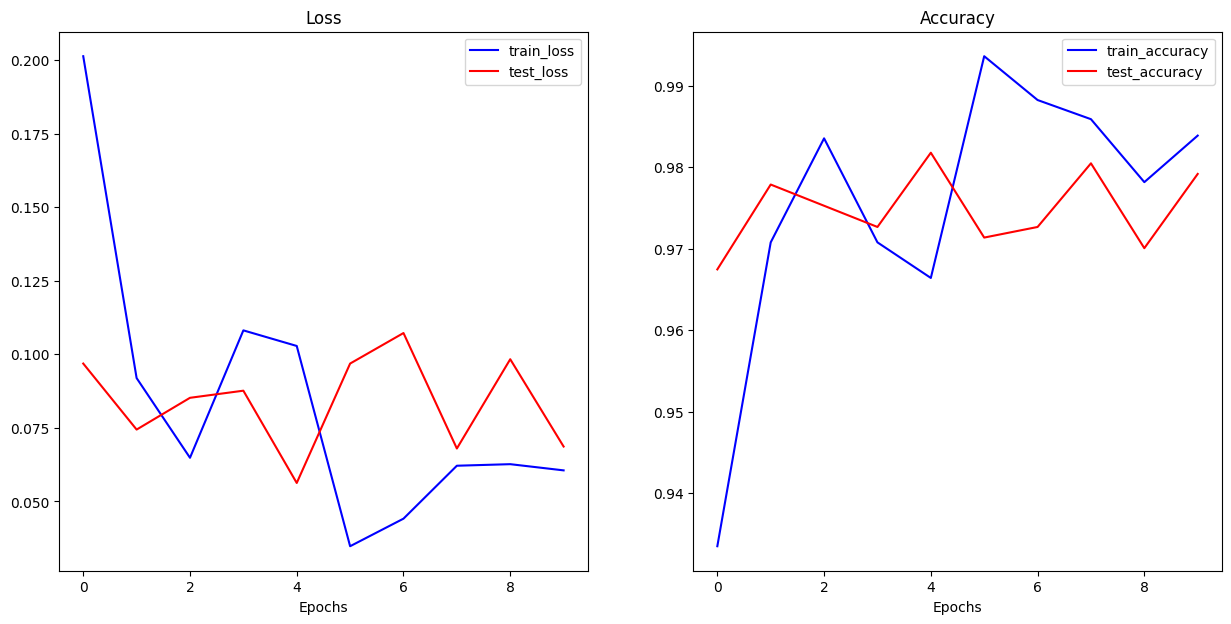

In [34]:
from helper_functions import plot_loss_curves
plot_loss_curves(model_results)

## 9 Predicting the label for a random image

Image downloaded!
random_image filepath: data/random_image.jpeg
[INFO] Total predicting time: 0.017 seconds


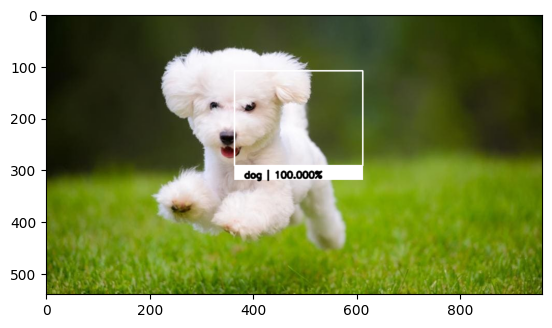

In [38]:
from helper_functions import predict_random_img
image_link = "https://thumbor.forbes.com/thumbor/fit-in/1290x/https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg"
predict_random_img(data_path=data_path,
                  image_link=image_link,
                  model=objectDetector,
                  class_names=class_names,
                  transform=test_transform,
                  device=device)

Image downloaded!
random_image filepath: data/random_image.jpeg
[INFO] Total predicting time: 0.019 seconds


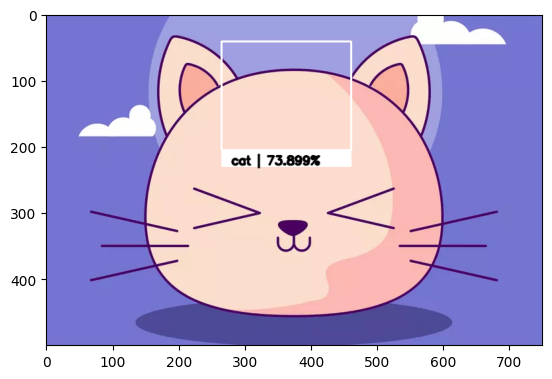

In [40]:
image_link = "https://www.dailypaws.com/thmb/BHV8IVy68trUQf1aoQVL0dK5MIo=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/anime-cat-names-1204854078-2000-d34f509ae54943d8b78cfb4bf9ba0678.jpg"
predict_random_img(data_path=data_path,
                  image_link=image_link,
                  model=objectDetector,
                  class_names=class_names,
                  transform=test_transform,
                  device=device)

Image downloaded!
random_image filepath: data/random_image.jpeg
[INFO] Total predicting time: 0.085 seconds


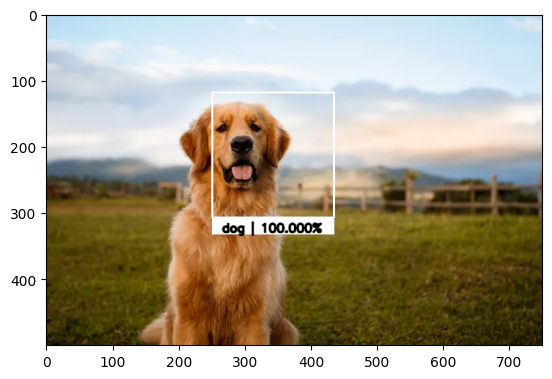

In [42]:
image_link = "https://www.southernliving.com/thmb/ZuS1MlY7N7G67Lyvl2zDIoktRDU=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/gettyimages-837898820-1-4deae142d4d0403dbb6cb542bfc56934.jpg"
predict_random_img(data_path=data_path,
                  image_link=image_link,
                  model=objectDetector,
                  class_names=class_names,
                  transform=test_transform,
                  device=device)

## 10 Checking the size of the model

In [43]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_resnet_model_size = Path("models/resnet_bbox_prediction_model.pth").stat().st_size // (1024*1024) # to convert bytes into MB
print(f"Resnet classificatrion and bounding box regression model size: {pretrained_resnet_model_size} MB")

Resnet classificatrion and bounding box regression model size: 96 MB


## 11 Gradio Demo

In [44]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.5 MB/s eta 0:

### 11.1 Predicting image on **CPU** as we don't have access to GPU in Gradio

In [46]:
from typing import Tuple, Dict

def predict(image: torch.tensor,
            class_names,
            model: torch.nn.Module,
            transform) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time
  taken.

  Args:
    image: image tensor which is in the RGB format
    le: label encoder for labelling the prediction
    model: model to predict the label and bbox of the image
    transform: transform for the image before putting it into the model
  """
  # getting height and width of the image
  h = image.shape[0]
  w = image.shape[1]

  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  image_resized = cv2.resize(image, (224, 224))
  image_resized = torch.tensor(image_resized)
  image_resized = image_resized.permute(2,0,1)
  image_transformed = transform(image_resized)

  # Put model into evaluation mode and turn on inference mode
  model.to("cpu")
  model.eval()
  with torch.inference_mode():
    image_transformed = image_transformed.unsqueeze(dim=0)
    bbox, label_logits = model(image_transformed)

  image_pred_probs = torch.softmax(label_logits, dim=1)
  target_image_pred_label = torch.argmax(image_pred_probs, dim=1)

  end_time = timer()
  print(f"[INFO] Total predicting time: {end_time-start_time:.3f} seconds")

  # Converting label code to label
  label = class_names[target_image_pred_label]
  title = f"{label} | {image_pred_probs.max()*100:.3f}%"

  # printing the image with the class, boundary box (bbox) and its probability
  (xmin, ymin, xmax, ymax) = bbox[0]
  startX = int(xmin * w)
  startY = int(ymin * h)
  endX = int(xmax * w)
  endY = int(ymax * h)

  font = cv2.FONT_HERSHEY_SIMPLEX
  color = (0,0,0)
  if h < 1000 and w < 1000:
    fontScale = 0.8
    thickness = 2
  else:
    fontScale = 5
    thickness = 12

  image = cv2.rectangle(image, (startX,startY), (endX,endY), (255,255,255), 2)
  image = cv2.rectangle(image,(startX,endY),(endX,endY+int(0.05*h)),(255,255,255),-1)
  image = cv2.putText(image,title,(startX+int(0.02*w),endY+int(0.045*h)),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

  # plt.imshow(image)
  return image

Image downloaded!
random_image filepath: data/random_image.jpeg
[INFO] Total predicting time: 0.635 seconds


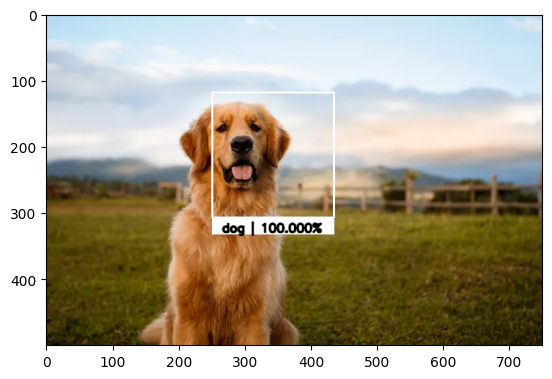

In [47]:
from helper_functions import download_random_img
# downloading the image
image_link = "https://www.southernliving.com/thmb/ZuS1MlY7N7G67Lyvl2zDIoktRDU=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/gettyimages-837898820-1-4deae142d4d0403dbb6cb542bfc56934.jpg"
image_filepath = download_random_img(data_path, image_link)
print(f"random_image filepath: {image_filepath}")

# reading the image
image = cv2.imread(str(image_filepath))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(predict(image=image,
        class_names=class_names,
        model=objectDetector,
        transform=test_transform))

### 11.2 Creating a Directory for **DEMO**

In [48]:
import shutil
from pathlib import Path

# Create demo path
classification_bbox_demo_path = Path("demos/classification_bbox/")

# Check if directory already exists
if classification_bbox_demo_path.exists():
    shutil.rmtree(classification_bbox_demo_path)
    classification_bbox_demo_path.mkdir(parents=True, exist_ok=True)
else:
    classification_bbox_demo_path.mkdir(parents=True, exist_ok=True)

### 11.3 Creating Examples sub-directory

In [49]:
import shutil
from pathlib import Path

# Create examples directory
classification_bbox_examples_path = classification_bbox_demo_path / "examples"
classification_bbox_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
classification_bbox_examples = [Path('data/cat_dog/images/Cats_Test154.png'),
                            Path('data/cat_dog/images/Cats_Test1210.png'),
                            Path('data/cat_dog/images/Cats_Test2211.png')]

# 3. Copy the three random images to the examples directory
for example in classification_bbox_examples:
    destination = classification_bbox_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)
print("Copy successful. All the files are copied to the examples directory!")

[INFO] Copying data/cat_dog/images/Cats_Test154.png to demos/classification_bbox/examples/Cats_Test154.png
Copy successful. All the files are copied to examples directory!
[INFO] Copying data/cat_dog/images/Cats_Test1210.png to demos/classification_bbox/examples/Cats_Test1210.png
Copy successful. All the files are copied to examples directory!
[INFO] Copying data/cat_dog/images/Cats_Test2211.png to demos/classification_bbox/examples/Cats_Test2211.png
Copy successful. All the files are copied to examples directory!


In [50]:
import os

# creating list if lists of examples as required by the gradio interface
example_list = [["examples/" + example] for example in os.listdir(classification_bbox_examples_path)]
example_list

[['examples/Cats_Test1210.png'],
 ['examples/Cats_Test2211.png'],
 ['examples/Cats_Test154.png']]

### 11.4 Moving model to demos/classification_bbox directory as per the Interface's requirements

In [51]:
import shutil

# source path for our model
model_path = "models/resnet_bbox_prediction_model.pth"

# destination path for our model
model_destination = classification_bbox_demo_path / model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_path} to {model_destination}")

    # Move the model
    shutil.move(src=model_path,
                dst=model_destination)

    print(f"[INFO] Model move completed successfully!!")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {model_destination}: {model_destination.exists()}")

[INFO] Attempting to move models/resnet_bbox_prediction_model.pth to demos/classification_bbox/resnet_bbox_prediction_model.pth
[INFO] Model move completed successfully!!


### 11.5 Copying `objectdetector.py` to `demos/classification_bbox`

In [52]:
src = Path("objectdetector.py")
destination = classification_bbox_demo_path / "objectdetector.py"
print(f"[INFO] Copying {example} to {destination}")
shutil.copy2(src=src, dst=destination)

[INFO] Copying data/cat_dog/images/Cats_Test2211.png to demos/classification_bbox/objectdetector.py


PosixPath('demos/classification_bbox/objectdetector.py')

### 11.6 Creating a function for creating an instance of our model in model.py file

In [53]:
%%writefile demos/classification_bbox/model.py
"""
This file contains the function to create and return an instance of our model
"""

import torch
import torchvision
from torch import nn
import objectdetector

def create_model(num_classes:int=2,
                seed:int=42):
    """Creates a Resnet feature extractor model.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 2.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): Resnet feature extractor model.
    """
    # downloading weights and creating teh base model
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    resnet = torchvision.models.resnet50(weights=weights)

    for param in resnet.parameters():
        param.requires_grad = False

    objectDetector = ObjectDetector(baseModel=resnet,
                                # in_features=resnet.fc.in_features,
                                numClasses=num_classes)
    return objectDetector

Writing demos/classification_bbox/model.py


### 11.7 Creating `app.py`

In [54]:
%%writefile demos/classification_bbox/app.py
"""
This file is the main file required by the Gradio Interface to run the demo.
"""

import gradio as gr
import os
import torch
from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["Cat", "Dog"]

# Create model
model = create_model(num_classes=len(class_names))

# Load saved weights
model.load_state_dict(
    torch.load(
        f="resnet_bbox_prediction_model.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

# Create predict function
def predict(image: torch.tensor,
            class_names,
            model: torch.nn.Module,
            transform):
  """Transforms and performs a prediction on img and returns prediction and time
  taken.

  Args:
    image: image tensor which is in the RGB format
    class_names: class names for labelling the prediction
    model: model to predict the label and bbox of the image
    transform: transform for the image before putting it into the model

  Returns:
    image: the annotated image
    bbox: bbox coordnaites
    time: prediction time in seconds
  """
  # getting height and width of the image
  h = image.shape[0]
  w = image.shape[1]

  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  image_resized = cv2.resize(image, (224, 224))
  image_resized = torch.tensor(image_resized)
  image_resized = image_resized.permute(2,0,1)
  image_transformed = transform(image_resized)

  # Put model into evaluation mode and turn on inference mode
  model.to("cpu")
  model.eval()
  with torch.inference_mode():
    image_transformed = image_transformed.unsqueeze(dim=0)
    bbox, label_logits = model(image_transformed)

  image_pred_probs = torch.softmax(label_logits, dim=1)
  target_image_pred_label = torch.argmax(image_pred_probs, dim=1)

  pred_time = round(timer() - start_time, 5)

  # Converting label code to label
  label = class_names[target_image_pred_label]
  title = f"{label} | {image_pred_probs.max()*100:.3f}%"

  # printing the image with the class, boundary box (bbox) and its probability
  (xmin, ymin, xmax, ymax) = bbox[0]
  startX = int(xmin * w)
  startY = int(ymin * h)
  endX = int(xmax * w)
  endY = int(ymax * h)

  font = cv2.FONT_HERSHEY_SIMPLEX
  color = (0,0,0)
  if h < 1000 and w < 1000:
    fontScale = 0.8
    thickness = 2
  else:
    fontScale = 5
    thickness = 12

  image = cv2.rectangle(image, (startX,startY), (endX,endY), (255,255,255), 2)
  image = cv2.rectangle(image,(startX,endY),(endX,endY+int(0.05*h)),(255,255,255),-1)
  image = cv2.putText(image,title,(startX+int(0.02*w),endY+int(0.045*h)),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

  # plt.imshow(image)
  return image, (startX, startY, endX, endY), pred_time

### Gradio app ###

# Create title, description and article strings
title = "Cat Dog classification with Bounding Box"
description = "A resnet feature extractor computer vision model to classify images of cats and dogs with bounding box."
article = "Created at [GitHub repo](https://github.com/m10singh94/ClassificationAndBoundingBoxPrediction.git)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=["image",
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/classification_bbox/app.py


### 11.8 Creating `requirements.txt`

In [57]:
%%writefile demos/classification_bbox/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/classification_bbox/requirements.txt


In [59]:
!ls demos/classification_bbox

app.py	  model.py	     requirements.txt
examples  objectdetector.py  resnet_bbox_prediction_model.pth


### 11.9 Downloading files

In [60]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/classification_bbox && zip -r ../classification_bbox.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/classification_bbox.zip")
    print("File downloaded!")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 58%)
  adding: examples/ (stored 0%)
  adding: examples/Cats_Test1210.png (deflated 0%)
  adding: examples/Cats_Test2211.png (deflated 0%)
  adding: examples/Cats_Test154.png (deflated 0%)
  adding: model.py (deflated 55%)
  adding: objectdetector.py (deflated 60%)
  adding: requirements.txt (deflated 4%)
  adding: resnet_bbox_prediction_model.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.10 Uploading to Hugging Face Spaces

In [1]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(
	src="https://maitreyisingh-classification-with-bbox.hf.space",
	width=850,
	height=450)